## Lesson Video:

# Lesson 2 - Image Classification Models from Scratch

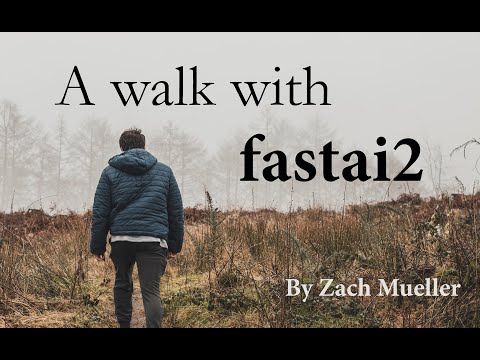

In [124]:
#hide_input
from IPython.lib.display import YouTubeVideo
YouTubeVideo('_SKqrTlXNt8')

In [ ]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [125]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.7.12 
* `fastcore` : 1.5.29 
* `wwf` : 0.0.16 
---

Grab our vision related libraries

In [126]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [127]:
from torch import nn

from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

And our data

In [128]:
path = untar_data(URLs.MNIST)

In [129]:
path

Path('/Users/hemanththaluru/.fastai/data/mnist_png')

## Working with the data

In [130]:
items = get_image_files(path)

In [ ]:
os.listdir(path)

In [131]:
len(items)

70000

Create an image object. Done automatically with `ImageBlock`.

In [132]:
im = PILImageBW.create(items[0])

In [133]:
PILImageBW.create()

TypeError: PILBase.create() missing 1 required positional argument: 'fn'

<Axes: >

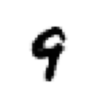

In [134]:
im.show()

Split our data with `GrandparentSplitter`, which will make use of a `train` and `valid` folder.

In [135]:
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [136]:
len(items)

70000

In [137]:
items[:3]

(#3) [Path('/Users/hemanththaluru/.fastai/data/mnist_png/training/9/36655.png'),Path('/Users/hemanththaluru/.fastai/data/mnist_png/training/9/32433.png'),Path('/Users/hemanththaluru/.fastai/data/mnist_png/training/9/28319.png')]

Splits need to be applied to some items

In [138]:
splits = splits(items)

In [ ]:
splits[0][:5],splits[1][:5]

* Make a `Datasets`

* Expects items, transforms for describing our problem, and a splitting method

In [139]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]],
                  splits=splits)

We can look at an item in our `Datasets` with `show_at`

In [ ]:
show_at(dsrc.valid,4)

We can see that it's a `PILImage` of a three, along with a label of `3`

Next we need to give ourselves some transforms on the data! These will need to:
1. Ensure our images are all the same size
2. Make sure our output are the `tensor` our models are wanting
3. Give some image augmentation

In [ ]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

* `ToTensor`: Converts to tensor
* `CropPad` and `RandomCrop`: Resizing transforms
* Applied on the `CPU` via `after_item`

In [ ]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

* `IntToFloatTensor`: Converts to a float
* `Normalize`: Normalizes data

In [ ]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

And show a batch

In [ ]:
dls.show_batch()

From here we need to see what our model will expect

In [140]:
xb, yb = dls.one_batch()

And now the shapes:

In [141]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [142]:
dls.c

10

So our input shape will be a [128 x 1 x 28 x 28] and our output shape will be a [128] tensor that we need to condense into 10 classes

## The Model

Our models are made up of **layers**, and each layer represents a matrix multiplication to end up with our final `y`. For this image problem, we will use a **Convolutional layer**, a **Batch Normalization layer**, an **Activation Function**, and a **Flattening layer**

### Convolutional Layer

These are always the first layer in our network. I will be borrowing an analogy from [here](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) by Adit Deshpande.

Our example Convolutional layer will be 5x5x1

Imagine a flashlight that is shining over the top left of an image, which covers a 5x5 section of pixels at one given moment. This flashlight then slides crosses our pixels at all areas in the picture. This flashlight is called a **filter**, which can also be called a **neuron** or **kernel**. The region it is currently looking over is called a **receptive field**. This filter is also an array of numbers called **weights** (or **parameters**). The depth of this filter **must** be the same as the depth of our input. In our case it is 1 (in a color image this is 3). Now once this filter begins moving (or **convolving**) around the image, it is multiplying the values inside this filter with the original pixel value of our image (also called **element wise multiplications**). These are then summed up (in our case this is just one multiplication of 28x28) to an individual value, which is a representation of **just** the top left of our image. Now repeat this until every unique location has a number and we will get what is called an **activation** or **feature map**. This feature map will be 784 different locations, which turns into a 28x28 array


In our model the Convolutional layer will 3x3 instead (kernel_size = 3) and it will move 2 pixels instead of 1 during each step (stride = 2) resulting in 14x14 feature map (as can be seen in `learner.summary()` below. To fully understand convolution layers and their parameters, there is an excellent tutorial [here](https://arxiv.org/pdf/1603.07285.pdf).

In [143]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1, bias=False)

Here we can see our `ni` is equivalent to the depth of the filter, and `nf` is equivalent to how many filters we will be using. (Fun fact this always has to be divisible by the size of our image).

### Batch Normalization

As we send our tensors through our model, it is important to normalize our data throughout the network. Doing so can allow for a much larger improvement in training speed, along with allowing each layer to learn independantly (as each layer is then re-normalized according to it's outputs)

In [144]:
def bn(nf): return nn.BatchNorm2d(nf)

`nf` will be the same as the filter output from our previous convolutional layer

### Activation functions

They give our models non-linearity and work with the `weights` we mentioned earlier along with a `bias` through a process called **back-propagation**. These allow our models to learn and perform more complex tasks because they can choose to fire or activate one of those neurons mentioned earlier. On a simple sense, let's look at the `ReLU` activation function. It operates by turning any negative values to zero, as visualized below:

![](https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png)

From "A Practical Guide to ReLU by Danqing Liu [URL](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7).

In [145]:
def ReLU(): return nn.ReLU(inplace=False)

### Flattening

The last bit we need to do is take all these activations and this outcoming matrix and flatten it into a single dimention of predictions. We do this with a `Flatten()` module

In [146]:
Flatten??

## Making a Model

* Five convolutional layers
* `nn.Sequential`
* 1 -> 32 -> 10

In [147]:
model = nn.Sequential(
    conv(1, 8),
    bn(8),
    ReLU(),
    conv(8, 16),
    bn(16),
    ReLU(),
    conv(16,32),
    bn(32),
    ReLU(),
    conv(32, 16),
    bn(16),
    ReLU(),
    conv(16, 10),
    bn(10),
    Flatten()
)

Now let's make our `Learner`

In [148]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

We can then also call `learn.summary` to take a look at all the sizes with their **exact** output shapes

In [84]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    72         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________

`learn.summary` also tells us:
* Total parameters
* Trainable parameters
* Optimizer
* Loss function
* Applied `Callbacks`

SuggestedLRs(valley=0.013182567432522774)

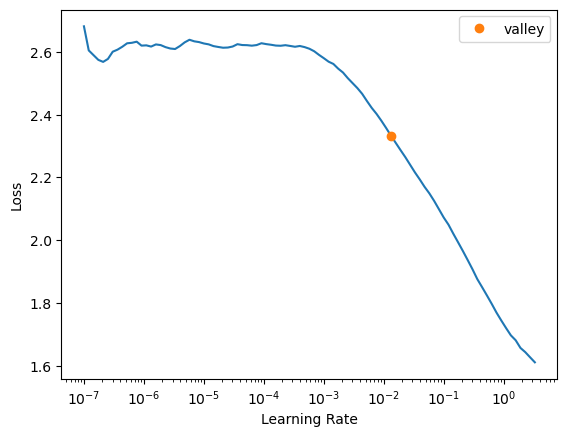

In [85]:
learn.lr_find()

Let's use a learning rate around 1e-1 (0.1)

In [86]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.218450,0.246538,0.920700,01:17
1,0.123160,0.086557,0.971800,01:16
2,0.069075,0.037855,0.988500,01:16


In [90]:
os.listdir()

['.DS_Store', 'mnist_png']

In [91]:
img = PILImage.create('/Volumes/THALURU/DS/Compt/Digit_Recogniser/digit-recognizer/data/test/0.jpg')

In [156]:
test_path='/Volumes/THALURU/DS/Compt/Digit_Recogniser/digit-recognizer/data/test'

In [119]:
test_path

'/Volumes/THALURU/DS/Compt/Digit_Recogniser/digit-recognizer/data/test'

In [163]:
test_items = get_image_files(test_path)

In [164]:
len(test_items)

28000

In [165]:
test_dl=learn.dls.test_dl(test_items)

In [166]:
preds, _ = learn.get_preds(dl=test_dl)
predicted_labels = preds.argmax(dim=1)

In [167]:
predicted_labels

tensor([4, 4, 9,  ..., 9, 9, 6])

In [168]:
from pathlib import Path
import os
compe='digit-recognizer'
iskaggle= os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if iskaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [169]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [170]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')

In [173]:
df_test.shape

(28000, 784)

In [174]:
import subprocess
def make_sub(pred_y,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['ImageId']=range(1, df_test.shape[0] + 1)
    df_submission['Label']=pred_y
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')

In [175]:
make_sub(predicted_labels,name='fsatai')

100%|██████████| 208k/208k [00:01<00:00, 209kB/s]  


Successfully submitted to Digit Recognizersuccesully saved - fsatai


## Simplify it

* Try to make it more like `ResNet`.
* `ConvLayer` contains a `Conv2d`, `BatchNorm2d`, and an activation function

In [ ]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

And make a new model

In [ ]:
net = nn.Sequential(
    conv2(1,8),
    conv2(8,16),
    conv2(16,32),
    conv2(32,16),
    conv2(16,10),
    Flatten()
)

Great! That looks much better to read! Let's make sure we get (roughly) the same results with it.

In [ ]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.220734,0.197168,0.933900,01:15
1,0.130333,0.075714,0.975800,01:14
2,0.078764,0.041104,0.987000,01:15


Almost the exact same! Perfect! Now let's get a bit more advanced

## ResNet (kinda)

The ResNet architecture is built with what are known as ResBlocks. Each of these blocks consist of two `ConvLayers` that we made before, where the number of filters do not change. Let's generate these layers.

In [ ]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)

  def forward(self, x): return x + self.conv2(self.conv1(x))

* Class notation
* `__init__`
* `foward`

Let's add these in between each of our `conv2` layers of that last model.

In [ ]:
net = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [ ]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

Awesome! We're building a pretty substantial model here. Let's try to make it **even simpler**. We know we call a convolutional layer before each `ResBlock` and they all have the same filters, so let's make that layer!

In [ ]:
def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [ ]:
net = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

And now we have something that resembles a ResNet! Let's see how it performs

In [ ]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

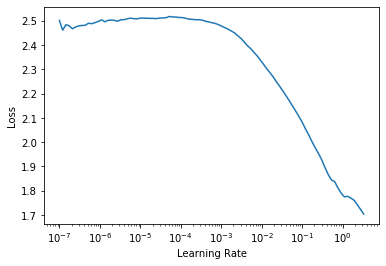

In [ ]:
learn.lr_find()

Let's do 1e-1 again

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.156825,0.904546,0.756200,01:16
1,0.089813,0.063087,0.980300,01:16
2,0.040906,0.025675,0.992200,01:18
